In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML
import os

In [2]:
# setting function

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines,y, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     print(y)
    top = int(y*0.5)
    bottom = y
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        #print(line)
        # Feel this is the brute force method, but I'm time constrained. I will research ideal numpy methods later.
        for x1,y1,x2,y2 in line:
            # Draw line segments in blue for error checking.
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1,y1,x2,y2)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # Don't error when a line cannot be drawn
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

def get_x(x,y,dy,slope):
    return
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,x,y):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    # Make a RGB shape of the correct dimensions
    shape = (img.shape[0], img.shape[1], 3)
    line_img = np.zeros(shape, dtype=np.uint8)
#     print(line_img)
    draw_lines(line_img, lines, y)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)








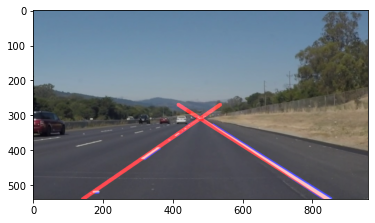

In [3]:

# testing process_image func on image
def process_image(image):
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)
    gaus = gaussian_noise(gray, 5)
    edges = canny(gaus, 50,150)    
    imshape = image.shape
#     print(imshape)
    
    
    vertices = np.array([[(0,imshape[0]),(int(imshape[1]*0.47),int(imshape[0]*0.6)), (int(imshape[1]*0.53),int(imshape[0]*0.6)), (imshape[1],imshape[0])]], dtype=np.int32)   
#     vertices = np.array([[(0,imshape[0]),(int(imshape[1]*0.47),int(imshape[0]*0.6)), (int(imshape[1]*0.53),int(imshape[0]*0.6)), (imshape[1],imshape[0])]], dtype=np.int32) 
    masked = region_of_interest(edges, vertices)
    
    rho = 2        #distance resolution in pixels of the Hough grid
    theta = np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 20    #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20  #minimum number of pixels making up a line
    max_line_gap = 20 #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap,imshape[1],imshape[0])
    
    result = weighted_img(line_image, image)
    return result



image = mpimg.imread('test_images/solidWhiteRight.jpg')
process = process_image(image)
plt.imshow(process)

    
    

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("challenge.mp4")
value=clip1.size
frame = clip1.get_frame(3)

# showing the frame with the help of matplotlib
# plt.imshow(frame, interpolation ='nearest')
# process = process_image(frame)
# plt.imshow(process)


white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
# %time output cpu time and complete time

t:   4%|▎         | 9/251 [00:00<00:02, 87.63it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
CPU times: user 3.67 s, sys: 706 ms, total: 4.37 s
Wall time: 5.2 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))